In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

import numpy as np
from math import log
import random
from itertools import combinations

from scipy.stats import chi2_contingency

from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA

In [2]:
sns.set_style('white')
sns.set_context('paper', font_scale=1)
sns.set_style('ticks', {'xtick.color': '0','ytick.color': '0'})
cmap = sns.cubehelix_palette(start=0, rot=0, dark=.1, light=.9, hue=0,as_cmap=True)
cmap_color = sns.cubehelix_palette(start=2.7, rot=0, dark=0.25, light=.9, as_cmap=True)
#palette = sns.cubehelix_palette(start=2.7, rot=0, dark=0.25, light=.9,hue=0)

ATTRIBUTES = ['Relevance','Rhetorical Quality','Logical Quality','Dialectical Quality']

## Data Import

In [3]:
df_arguments = pd.read_csv("./data/arguments.csv")
df_annotators = pd.read_csv("./data/annotators.csv")
df_topics = pd.read_csv("./data/topics.csv")
df_rankings = pd.read_csv("./data/rankings.csv")

## Annotators

### Overall

Overall distribution of annotator age:

In [4]:
df_annotators['Age'].describe()

count    39.000000
mean     24.794872
std       9.616815
min      18.000000
25%      19.000000
50%      20.000000
75%      24.500000
max      53.000000
Name: Age, dtype: float64

In [5]:
f = sns.boxplot(data=df_annotators,x='Age',color="white")
plt.setp(f.artists, edgecolor = 'k', facecolor='w')
plt.setp(f.lines, color='k')
sns.despine(left=True,right=True,top=True)
f.get_figure().savefig("./plots/annotators_age.eps",format='eps',dpi=300)

Distribution of annotator gender:

In [6]:
f = sns.countplot(df_annotators['Gender'],color="w",edgecolor='k')
sns.despine(left=True,right=True,top=True)
f.get_figure().savefig("./plots/annotators_gender.eps",format='eps',dpi=300)

Combinded plot for age and gender:

In [7]:
f = sns.stripplot(x='Gender',y='Age',data=df_annotators,color="k")
sns.despine(left=True,right=True,top=True)
f.get_figure().savefig("./plots/annotators_distribution.eps",format='eps',dpi=300)

Distribution of age per gender:

In [8]:
male =  (
    df_annotators
    .loc[df_annotators['Gender'] == 'male',['Age']]
    .describe()
    .rename({"Age":"Male"},axis=1)
    .round(2)
)
female = (
    df_annotators
    .loc[df_annotators['Gender'] == 'female',['Age']]
    .describe()
    .rename({"Age":"Female"},axis=1)
    .round(2)
)
female.join(male)

Female   Male
count    8.00  31.00
mean    28.00  23.97
std     15.46   7.61
min     18.00  19.00
25%     19.75  19.00
50%     20.00  20.00
75%     29.00  24.50
max     53.00  38.00

# Argument Quality

## Corpus statistics

In [9]:
len(df_arguments)

494

In [10]:
len(df_arguments.loc[df_arguments['Is Argument?'] == True]),len(df_arguments.loc[df_arguments['Is Argument?'] == False])

(437, 57)

In [11]:
len(df_arguments.loc[(df_arguments.duplicated(subset=['Argument ID','Discussion ID'],keep=False)),:])

242

In [12]:
len(df_arguments.drop_duplicates(subset=['Discussion ID','Argument ID'],keep=False))

252

In [13]:
df_arguments.loc[df_arguments.duplicated(subset=['Discussion ID','Argument ID'],keep=False),:].groupby(['Discussion ID','Argument ID']).count()['Topic ID'].max()

2

In [14]:
len(df_arguments.loc[(df_arguments['Is Argument?'] == True)&(df_arguments['Stance']=='Not specified'),:])

34

## Distribution

Count Pro/Con-Arguments:

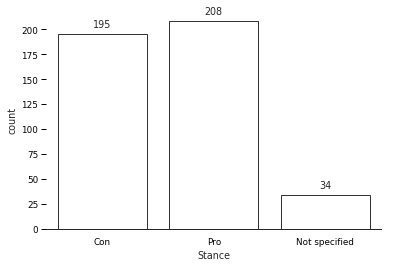

In [15]:
f = sns.countplot(df_arguments.loc[(df_arguments['Is Argument?'] == True),'Stance'], color="w",edgecolor='k')
sns.despine(left=True,bottom=False,right=True,top=True)
for p in f.patches:
        f.annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 10), textcoords='offset points')
f.tick_params(bottom=False)
f.get_figure().savefig("./plots/attributes_distribution_stance.eps",format='eps',dpi=300)

Overall distribution of argument quality scores:

In [16]:
f, axes = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
sns.despine(left=True,bottom=True,right=True,top=True)

for i,quality in enumerate(ATTRIBUTES):
    sns.countplot(df_arguments.loc[(df_arguments['Is Argument?'] == True),quality], color="w",edgecolor='k', ax=axes[i]).tick_params(bottom=False)
    for p in axes[i].patches:
        axes[i].annotate("%d" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 10), textcoords='offset points')
sns.despine(bottom=False,left=True)
f.savefig("./plots/attributes_distribution_full.eps",format='eps',dpi=300)

Argument quality score counts per quality for pro arguments only:

Argument quality score counts per quality for con arguments only:

## Correlation

Considering all Arguments:

In [17]:
df_arguments.loc[(df_arguments['Is Argument?']==True),ATTRIBUTES].corr().round(2)

Relevance  Rhetorical Quality  Logical Quality  \
Relevance                 1.00                0.38             0.48   
Rhetorical Quality        0.38                1.00             0.65   
Logical Quality           0.48                0.65             1.00   
Dialectical Quality       0.70                0.60             0.69   

                     Dialectical Quality  
Relevance                           0.70  
Rhetorical Quality                  0.60  
Logical Quality                     0.69  
Dialectical Quality                 1.00

Considering only pro arguments:

In [18]:
df_arguments.loc[(df_arguments['Is Argument?']==True) & (df_arguments['Stance'] == 'Pro'),ATTRIBUTES].corr().round(2)

Relevance  Rhetorical Quality  Logical Quality  \
Relevance                 1.00                0.42             0.48   
Rhetorical Quality        0.42                1.00             0.66   
Logical Quality           0.48                0.66             1.00   
Dialectical Quality       0.68                0.62             0.70   

                     Dialectical Quality  
Relevance                           0.68  
Rhetorical Quality                  0.62  
Logical Quality                     0.70  
Dialectical Quality                 1.00

Considering only false arguments:

In [19]:
df_arguments.loc[(df_arguments['Is Argument?']==True) & (df_arguments['Stance'] == 'Con'),ATTRIBUTES].corr()

Relevance  Rhetorical Quality  Logical Quality  \
Relevance             1.000000            0.344435         0.467021   
Rhetorical Quality    0.344435            1.000000         0.636850   
Logical Quality       0.467021            0.636850         1.000000   
Dialectical Quality   0.734758            0.561670         0.675551   

                     Dialectical Quality  
Relevance                       0.734758  
Rhetorical Quality              0.561670  
Logical Quality                 0.675551  
Dialectical Quality             1.000000

## Contingency

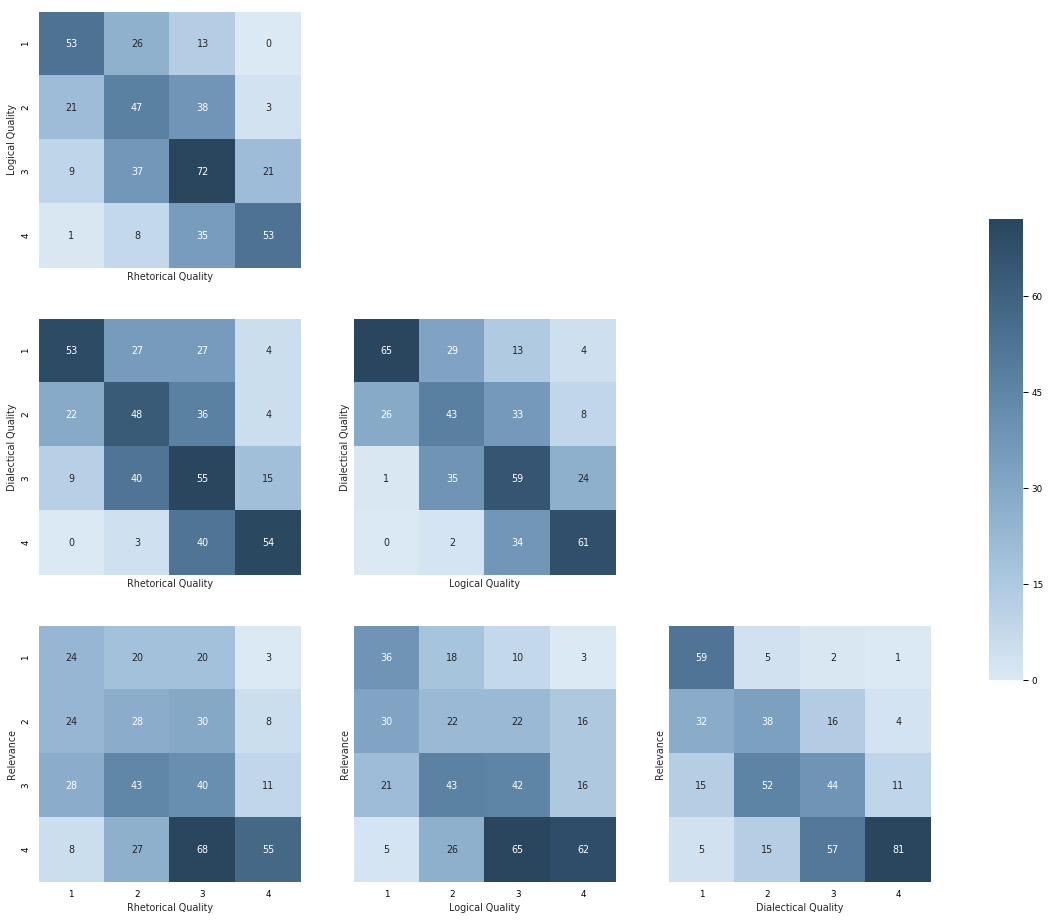

In [20]:
f, axes = plt.subplots(3, 3, figsize=(16, 16), sharex=True, sharey=True)
sns.despine(left=True, bottom=True)
cbar_ax = f.add_axes([0.95, .3, .03, .4])
  
sns.heatmap(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,'Logical Quality'], df_arguments.loc[df_arguments['Is Argument?'] == True,'Rhetorical Quality']), cmap=cmap_color, annot=True, ax=axes[0,0], cbar_ax=cbar_ax).tick_params(bottom=False,right=False,left=False,top=False)
sns.heatmap(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,'Dialectical Quality'], df_arguments.loc[df_arguments['Is Argument?'] == True,'Logical Quality']), cmap=cmap_color, annot=True, ax=axes[1,1], cbar=None).tick_params(bottom=False,right=False,left=False,top=False)
sns.heatmap(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,'Dialectical Quality'], df_arguments.loc[df_arguments['Is Argument?'] == True,'Rhetorical Quality']), cmap=cmap_color, annot=True, ax=axes[1,0], cbar=None).tick_params(bottom=False,right=False,left=False,top=False)
sns.heatmap(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,'Relevance'], df_arguments.loc[df_arguments['Is Argument?'] == True,'Logical Quality']), cmap=cmap_color, annot=True, ax=axes[2,1], cbar=None).tick_params(bottom=False,right=False,left=False,top=False)
sns.heatmap(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,'Relevance'], df_arguments.loc[df_arguments['Is Argument?'] == True,'Rhetorical Quality']), cmap=cmap_color, annot=True, ax=axes[2,0], cbar=None).tick_params(bottom=False,right=False,left=False,top=False)
sns.heatmap(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,'Relevance'], df_arguments.loc[df_arguments['Is Argument?'] == True,'Dialectical Quality']), cmap=cmap_color, annot=True, ax=axes[2,2], cbar=None).tick_params(bottom=False,right=False,left=False,top=False)
axes[0,1].tick_params(bottom=False,right=False,left=False,top=False)
axes[0,2].tick_params(bottom=False,right=False,left=False,top=False)
axes[1,2].tick_params(bottom=False,right=False,left=False,top=False)

f.savefig("./plots/attributes_contingency_full.eps",format='eps',dpi=300)

### Chi-Square Test

In [21]:
df_chi = pd.DataFrame(index=ATTRIBUTES,columns=ATTRIBUTES)
for pair in combinations(ATTRIBUTES,2):
    chi, p, dof = chi2_contingency(pd.crosstab(df_arguments.loc[df_arguments['Is Argument?'] == True,pair[1]], df_arguments.loc[df_arguments['Is Argument?'] == True,pair[0]]))[0:3]
    df_chi.loc[pair[1],pair[0]] = chi
df_chi.fillna('-')

Relevance Rhetorical Quality Logical Quality  \
Relevance                   -                  -               -   
Rhetorical Quality    84.6164                  -               -   
Logical Quality       122.771            249.785               -   
Dialectical Quality   316.021            222.779         275.475   

                    Dialectical Quality  
Relevance                             -  
Rhetorical Quality                    -  
Logical Quality                       -  
Dialectical Quality                   -

### Principal component analysis

Since all variables are highly interdependent, the assumption that they are all associated with a latent variable can be derived. This latent variable may represent the *overall argument quality*.

In [22]:
pca = PCA().fit(df_arguments.loc[(df_arguments['Is Argument?']==True),ATTRIBUTES[1:]])

In [23]:
pd.DataFrame(pca.components_, columns=ATTRIBUTES[1:])

Rhetorical Quality  Logical Quality  Dialectical Quality
0           -0.520546        -0.595493            -0.611898
1            0.753354         0.016967            -0.657396
2           -0.401857         0.803181            -0.439785

In [24]:
pd.DataFrame({'Singular Values':pca.singular_values_,'Explained variance ratio':pca.explained_variance_ratio_})

Singular Values  Explained variance ratio
0        33.285825                  0.768467
1        13.763226                  0.131385
2        12.016217                  0.100148

## Agreement

Quadratic-weighted Cohen-$\kappa$ was used to measure agreement between observations for each argument quality. Overall, a low agreement is visible.

In [25]:
agreements = []
for dimension in ATTRIBUTES[1:]:
    df_multiples = (  
        df_arguments
        .loc[(df_arguments.duplicated(subset=['Argument ID','Discussion ID'],keep=False))&(df_arguments['Is Argument?']==True),:]
                .groupby(['Discussion ID','Argument ID'])
                .count()
                .reset_index()
        .loc[
            (
                df_arguments
                .loc[(df_arguments.duplicated(subset=['Argument ID','Discussion ID'],keep=False))&(df_arguments['Is Argument?']==True),:]
                .groupby(['Discussion ID','Argument ID'])
                .count()
                .reset_index()
            )['Topic ID'] == 2
            ,['Discussion ID','Argument ID']
        ]
        .merge(df_arguments,how='left',on=['Discussion ID','Argument ID'])
    ).loc[:,[dimension,'Discussion ID','Argument ID']]

    df_multiples['Annotation Set'] = df_multiples.groupby(['Discussion ID','Argument ID']).cumcount()
    df_multiples['Unique'] = df_multiples.apply(lambda x : str(x['Discussion ID'])+"-"+str(x['Argument ID']), axis=1)
    df_multiples = df_multiples.pivot(index = 'Annotation Set',values=dimension,columns='Unique')
    df_multiples.columns = range(0,len(df_multiples.columns))
    df_multiples = df_multiples.reset_index(drop=True)
    agreements.append({"Dimension":dimension,"Cohen-K":cohen_kappa_score(df_multiples.loc[0,:],df_multiples.loc[1,:],weights='quadratic')})
pd.DataFrame(agreements)

Cohen-K            Dimension
0  0.422534   Rhetorical Quality
1  0.386359      Logical Quality
2  0.403835  Dialectical Quality

In [26]:
# Rand. Score for comparison
cohen_kappa_score([random.randint(1, 4) for r in range(100)],[random.randint(1, 4) for r in range(100)],weights='quadratic')

-0.19760479041916157

In [27]:
# Off-by-one score for comparison
l = [random.randint(1, 4) for r in range(100)]
print('Linear Weighting: {}'.format(cohen_kappa_score(l,[x-1 for x in l],weights='linear')))
print('Quadratic Weighting: {}'.format(cohen_kappa_score(l,[x-1 for x in l],weights='quadratic')))

Linear Weighting: 0.34657605854678497
Quadratic Weighting: 0.7238179407865666


In [28]:
# Off-by-two score for comparison
l = [random.randint(1, 4) for r in range(100)]
print('Linear Weighting: {}'.format(cohen_kappa_score(l,[x-2 for x in l],weights='linear')))
print('Quadratic Weighting: {}'.format(cohen_kappa_score(l,[x-2 for x in l],weights='quadratic')))

Linear Weighting: 0.07338769458858407
Quadratic Weighting: 0.4070736118110937


## Bias

In [29]:
biased_topics = df_topics[df_topics['Biased']==True]
unbiased_topics = df_topics[df_topics['Biased']==False]

arguments_bias = biased_topics.merge(df_arguments[df_arguments['Stance']!='Not specified'], how='left',on='Topic ID')

Mean argument scores by anntator stance cross-tabulation. No significant effect of annotator stance towards the topic.

In [30]:
df_bias = (
    df_topics[df_topics['Biased']==True]
    .merge(df_arguments[df_arguments['Stance']!='Not specified'], how='left',on='Topic ID')
    .loc[:,['Annotator Stance','Stance',*ATTRIBUTES]]
    .groupby(['Annotator Stance','Stance'],axis=0)
    .mean()
    .round(2)
    .unstack('Stance')
)

df_bias = (
    df_bias
    .append(df_bias.loc['I agree'].mul(df_bias.loc['Neutral']),ignore_index=True)
    .append(df_bias.loc['I disagree'].mul(df_bias.loc['Neutral']),ignore_index=True)
    .rename({0:'Pro',1:'Con',2:'Neutral',3:'Pro Corrected',4:'Con Corrected'})
)
df_bias

Relevance         Rhetorical Quality         Logical Quality  \
Stance              Con     Pro                Con     Pro             Con   
Pro              1.8900  2.1500             1.7300  1.8800          1.7500   
Con              2.2200  2.1400             2.2500  1.8800          1.9800   
Neutral          1.5800  1.7600             1.7500  1.4700          1.4200   
Pro Corrected    2.9862  3.7840             3.0275  2.7636          2.4850   
Con Corrected    3.5076  3.7664             3.9375  2.7636          2.8116   

                      Dialectical Quality          
Stance            Pro                 Con     Pro  
Pro            1.9700              1.6100  1.8200  
Con            2.0900              1.8800  1.8600  
Neutral        1.2900              1.3300  1.2400  
Pro Corrected  2.5413              2.1413  2.2568  
Con Corrected  2.6961              2.5004  2.3064

## Ranking

In [31]:
def ndcg(ideal_ranking, real_ranking, k):
    """
    :param ideal_ranking: list of ideal ranking entry tuples in the form of (rank,value)
    :param real_ranking: list of real ranking entry tuples in the form of (rank,value)
    :param k: first k entries of the ranking are used to calculate the dcg score
    :param normalize_fnc: function used to normalize passed values
    :return: normalized discounted cumluative gain at k for passed ideal and real ranking
    """
    dcg = lambda ranking,k : sum(
        [(2**value - 1) / log(1 + rank, 2) for rank, value in ranking[0:k]]
    )
    return dcg(real_ranking,k) / dcg(ideal_ranking,k)

### Mean NDCG Scores Overall

In [32]:
dfs_ndcg = []

for engine in df_rankings['Engine'].unique(): # Per engine
    for dimension in ATTRIBUTES: # Per quality dimensions
        for topic in df_topics['Topic ID'].unique(): # Per topic
            real_ranking = (
                df_rankings
                .loc[(df_rankings['Engine'] == engine) & (df_rankings['Topic ID'] == topic),:] # Consider only rankings for current engine & topic
                .sort_values('Rank',axis=0,ascending=True) # Sort Ranking from low to high
                .merge(df_arguments,how='left',on=['Discussion ID','Argument ID','Topic ID']) # Add argument qualities for every argument in the ranking
            )
            ideal_ranking = (
                df_arguments
                .loc[df_arguments['Topic ID'] == topic,:]
                .sort_values(dimension, axis=0, ascending=False)  # Sort from high to low for current dimension
            )
            score = ndcg([t for t in enumerate(list(ideal_ranking[dimension]),start=1)],[t for t in enumerate(list(real_ranking[dimension]),start=1)],5)
            dfs_ndcg.append({"Engine":engine,"Dimension":dimension,"NDCG-Score":score,"Topic":topic})

df_ndcg = pd.DataFrame(dfs_ndcg)

In [33]:
(
    df_ndcg
    .drop("Topic",axis=1)
    .groupby(["Engine","Dimension"], axis=0)
    .mean()
    .round(3)
    .unstack('Dimension')
)

NDCG-Score                            \
Dimension          Dialectical Quality Logical Quality Relevance   
Engine                                                             
args                             0.424           0.419     0.458   
terrierDPH                       0.645           0.639     0.664   
terrierDirichletLM               0.648           0.691     0.643   
terrierTF_IDF                    0.473           0.489     0.555   

                                       
Dimension          Rhetorical Quality  
Engine                                 
args                            0.445  
terrierDPH                      0.671  
terrierDirichletLM              0.695  
terrierTF_IDF                   0.463

#### Bootstrapping for confidence intervals

Bootstrapping ($n = 10000, f=0.5, \alpha=0.95$) is used to determine confidence intervals for the NDCG scores. Drawing 20 topics random topics with replacement for every engine and dimension, a mean NDCG score was computed 10000 times. The resulting distributions are displayed in Figure X, the calculate confidence intervals for $\alpha=0.95$ are shown in Table Y.

In [34]:
# This can take a while
n = 10000
a = 0.05

df_confidence = []
for engine in df_ndcg['Engine'].unique():
    for dimension in ATTRIBUTES:
        samples = sorted([
                (
                    df_ndcg
                    .loc[(df_ndcg['Engine'] == engine) & (df_ndcg['Dimension'] == dimension),'NDCG-Score']
                    .sample(replace=True,frac=1)
                    .mean()
                ) 
                for i in range(n)
        ])
        lower = samples[int(len(samples)*a)]
        upper = samples[int(len(samples)*(1-a))]
        df_confidence.append({"Engine":engine,"Dimension":dimension,"Lower Bound":lower,"Upper Bound":upper})

df_confidence = pd.DataFrame(df_confidence)

In [35]:
df_confidence = df_confidence.pivot(index='Engine',columns='Dimension',values=['Upper Bound','Lower Bound'])
df_confidence.columns = df_confidence.columns.swaplevel(0,1)
df_confidence.sort_index(level=0, axis=1, inplace=True)
df_confidence.round(2)

Dimension          Dialectical Quality             Logical Quality  \
                           Lower Bound Upper Bound     Lower Bound   
Engine                                                               
args                              0.37        0.48            0.36   
terrierDPH                        0.60        0.71            0.60   
terrierDirichletLM                0.60        0.70            0.65   
terrierTF_IDF                     0.41        0.52            0.43   

Dimension                        Relevance             Rhetorical Quality  \
                   Upper Bound Lower Bound Upper Bound        Lower Bound   
Engine                                                                      
args                      0.46        0.41        0.50               0.40   
terrierDPH                0.70        0.61        0.72               0.61   
terrierDirichletLM        0.75        0.59        0.69               0.65   
terrierTF_IDF             0.56        0.50        0.62               0.38   

Dimension                       
                   Upper Bound  
Engine                          
args                      0.50  
terrierDPH                0.73  
terrierDirichletLM        0.73  
terrierTF_IDF             0.54

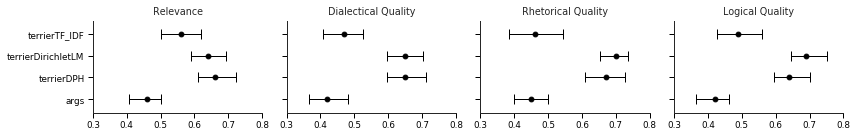

In [36]:
f, axes = plt.subplots(1, 4, figsize=(12, 2), sharex=True, sharey=True)
def draw_plot(dimension,i):
    uppers = df_confidence[dimension]['Upper Bound']
    lowers = df_confidence[dimension]['Lower Bound']
    means = (
        df_ndcg
        .drop("Topic",axis=1)
        .groupby(["Engine","Dimension"], axis=0)
        .mean()
        .round(2)
        .unstack('Dimension')
    )['NDCG-Score'][dimension]
    x = means
    xerr = [abs(means-lowers), abs(uppers-means)]
    y = list(df_confidence.index)
    axes[i].errorbar(x, y, xerr=xerr, fmt = 'o', color = 'k',elinewidth=1,capsize=5,capthick=1)
    axes[i].set_title(dimension)
    axes[i].set_xlim([0.3,0.8])
    axes[i].margins(x=0.2, y=0.2, tight=True)
    sns.despine(left=False,right=True,top=True,bottom=False)

for i, dimension in enumerate(['Relevance','Dialectical Quality','Rhetorical Quality','Logical Quality']):
    draw_plot(dimension,i)

f.tight_layout()
f.savefig("./plots/ndcg_confidence.eps",format='eps',dpi=300)

#### Significance Test ANOVA

In [37]:
from scipy.stats import f_oneway

df_significance = pd.DataFrame(index=pd.MultiIndex.from_product([ATTRIBUTES,df_ndcg['Engine'].unique()], names=['Dimension', 'Engine']),columns=df_ndcg['Engine'].unique())
for engine1,engine2 in combinations(df_ndcg['Engine'].unique(),2):
    for dimension in ATTRIBUTES:
        t1 = (
            df_ndcg
            .loc[(df_ndcg['Engine'] == engine1) & (df_ndcg['Dimension'] == dimension),'NDCG-Score']
        )
        t2 = (
            df_ndcg
            .loc[(df_ndcg['Engine'] == engine2) & (df_ndcg['Dimension'] == dimension),'NDCG-Score']
        )
        stat, p = f_oneway(t1,t2)
        df_significance.loc[(dimension,engine1),engine2] = p.round(4)
df_significance.dropna(how='all').fillna('').transpose()

Dimension          Relevance                               Rhetorical Quality  \
Engine                  args terrierDPH terrierDirichletLM               args   
args                                                                            
terrierDPH                 0                                                0   
terrierDirichletLM         0     0.6225                                     0   
terrierTF_IDF         0.0562     0.0313             0.0724             0.7425   

Dimension                                        Logical Quality             \
Engine             terrierDPH terrierDirichletLM            args terrierDPH   
args                                                                          
terrierDPH                                                     0              
terrierDirichletLM     0.5777                                  0     0.2472   
terrierTF_IDF          0.0004                  0           0.164     0.0047   

Dimension                             Dialectical Quality             \
Engine             terrierDirichletLM                args terrierDPH   
args                                                                   
terrierDPH                                              0              
terrierDirichletLM                                      0     0.9488   
terrierTF_IDF                  0.0001              0.3446     0.0015   

Dimension                              
Engine             terrierDirichletLM  
args                                   
terrierDPH                             
terrierDirichletLM                     
terrierTF_IDF                   0.001

## NDCG Plots

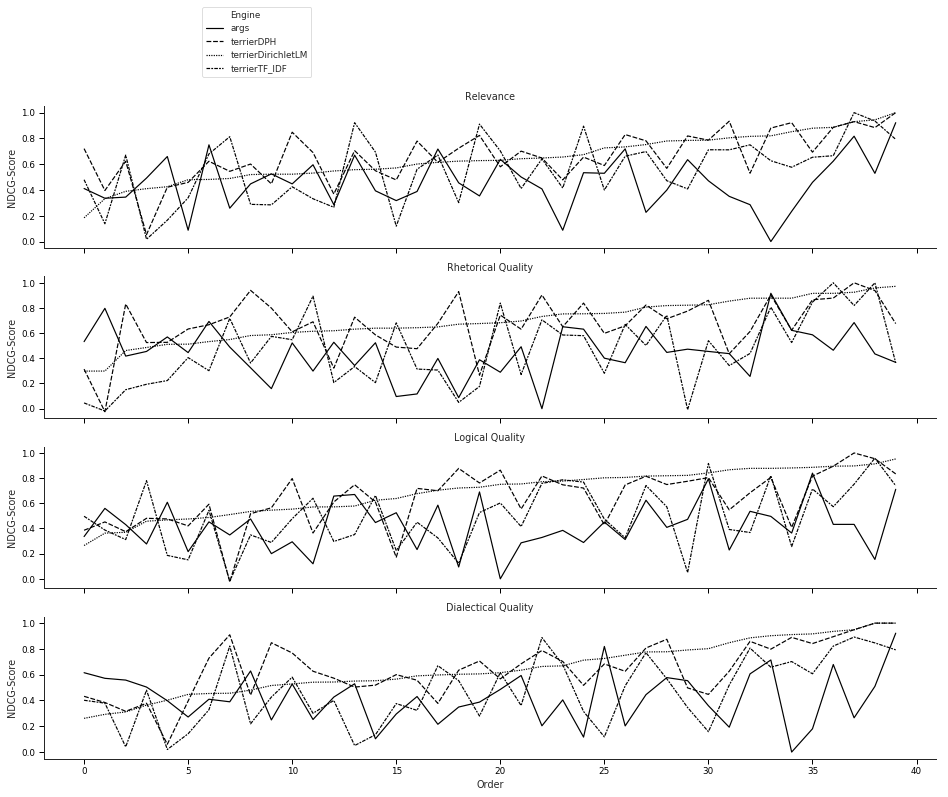

In [38]:
f, ax = plt.subplots(4, 1, figsize=(16, 12),sharex=True)

for i,dimension in enumerate(ATTRIBUTES,start=0):
    order = (
        df_ndcg
        .loc[df_ndcg['Dimension']==dimension,:]
        .loc[df_ndcg['Engine'] == 'terrierDirichletLM',:]
        .sort_values('NDCG-Score')
        .reset_index(drop=True)
        .reset_index()
        .rename({'index':'Order'},axis=1)
    ).loc[:,['Order','Topic']]
    ax[i].set_title(dimension)
    f_ax = sns.lineplot(data=pd.concat([
        (
            df_ndcg
            .loc[df_ndcg['Dimension']==dimension]
            .loc[df_ndcg['Engine'] == 'args']
            .merge(order,how='left',on='Topic')
        ),
        (
            df_ndcg
            .loc[df_ndcg['Dimension']==dimension]
            .loc[df_ndcg['Engine'] == 'terrierDPH']
            .merge(order,how='left',on='Topic')
        ),
        (
            df_ndcg
            .loc[df_ndcg['Dimension']==dimension]
            .loc[df_ndcg['Engine'] == 'terrierDirichletLM']
            .merge(order,how='left',on='Topic')
        ),
        (
            df_ndcg
            .loc[df_ndcg['Dimension']==dimension]
            .loc[df_ndcg['Engine'] == 'terrierTF_IDF']
            .merge(order,how='left',on='Topic')
        )
    ]),x='Order',y='NDCG-Score',style='Engine',legend='full',ax=ax[i])
    plt.setp(f_ax.artists, edgecolor = 'k', facecolor='w')
    plt.setp(f_ax.lines, color='k')
    if i==0:
        ax[i].legend(bbox_to_anchor=(0.3, 1.7), loc=1, borderaxespad=0.)
    else:
         ax[i].get_legend().remove()
sns.despine()

f.savefig("./plots/ndcg_ordered_full.eps",format='eps',dpi=300)

#### NDCG Variance

In [39]:
(
    df_ndcg
    .drop("Topic",axis=1)
    .groupby(["Engine","Dimension"], axis=0)
    .var()
    .round(4)
    .unstack('Dimension')
)

NDCG-Score                            \
Dimension          Dialectical Quality Logical Quality Relevance   
Engine                                                             
args                            0.0406          0.0377    0.0399   
terrierDPH                      0.0452          0.0475    0.0374   
terrierDirichletLM              0.0407          0.0317    0.0326   
terrierTF_IDF                   0.0654          0.0596    0.0612   

                                       
Dimension          Rhetorical Quality  
Engine                                 
args                           0.0371  
terrierDPH                     0.0449  
terrierDirichletLM             0.0279  
terrierTF_IDF                  0.0791

In [40]:
f, ax = plt.subplots(1, 4, figsize=(16, 4),sharex=True,sharey=True)
for i,dimension in enumerate(ATTRIBUTES):
    f = sns.boxplot(data=df_ndcg.loc[df_ndcg['Dimension']==dimension],y='Engine',x='NDCG-Score',ax=ax[i],color="white")
    ax[i].set_title(dimension)
    plt.setp(f.artists, edgecolor = 'k', facecolor='w')
    plt.setp(f.lines, color='k')
    
sns.despine(offset=5, trim=True)

f.get_figure().savefig("./plots/ndcg_box_full.eps",format='eps',dpi=300)